#  Проект 4

**Задание**:
Приложение для обработки и оформления фотографий в формате Stories. 
Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. 

**основная задача** 
- проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

**Данные:**

    active_users – информация о пользователях, которые посещали приложение во время эксперимента. 
    groups – разбивка пользователей на контрольную (А) и тестовую (В) группы. 
    purchases – данные о транзакциях (оплатах) пользователей приложения во время эксперимента 

### Заливка библиотек

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tqdm.auto import tqdm
import seaborn as sns
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

plt.style.use('ggplot')

# Вывод всех строк таблицы на экран
from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 50

### Заливка данных

In [2]:
# Заливка данных
from io import BytesIO
import requests

spreadsheet_id = '1dx926tBnILlRGw0kFzR9_8IWsQILbfw6suFegCj5dsE'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)

active_users = pd.read_csv(BytesIO(r.content))
active_users.head()

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


In [3]:
active_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   8341 non-null   int64 
 1   country   8341 non-null   object
 2   platform  8341 non-null   object
 3   sex       8341 non-null   object
dtypes: int64(1), object(3)
memory usage: 260.8+ KB


In [4]:
# Заливка данных
from io import BytesIO
import requests

spreadsheet_id = '1FMuRBG3EwsHN2OK1RBjfHsZoLy786Aaoo2ISLq8GKhg'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)

groups = pd.read_csv(BytesIO(r.content))
groups.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [5]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  74576 non-null  int64 
 1   group    74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [6]:
# Заливка данных
from io import BytesIO
import requests

spreadsheet_id = '1vG4ipywcMliOFPjd6qqvO56uOR6Aj3M5GXzkfn87sJM'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)

purchases = pd.read_csv(BytesIO(r.content))
purchases.head()

,user_id,revenue
0,4412,"1,000.00"
1,9000,701.00
2,9001,700.00
3,9002,702.00
4,5790,"1,002.00"


In [7]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  541 non-null    int64  
 1   revenue  541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


### Вывод
В данных пропусков нет, все поля в нужных форматах.

### Расчетная часть

In [8]:
# Страны в данных
active_users_by_country = active_users.pivot_table(index='country', values='user_id', aggfunc='count').reset_index()

active_users_by_country['%'] = (active_users_by_country['user_id'] / active_users_by_country['user_id'].sum()).mul(100)
active_users_by_country 

,country,user_id,%
0,Russia,5407,64.82
1,Sweden,2934,35.18


In [9]:
# Соединяем таблицы
df = active_users.merge(groups, on='user_id') \
.merge(purchases, how='left', on='user_id').fillna(0)

In [10]:
def revenue_by(df, x1):
    df1 = df.pivot_table(index='country', \
    columns=x1, values='revenue', aggfunc='sum').reset_index()
    return df1

In [11]:
revenue_by_platform_and_country = revenue_by(df, 'platform')
revenue_by_platform_and_country

platform,country,android,ios
0,Russia,"145,068.00","129,781.00"
1,Sweden,"103,112.00","93,750.00"


In [12]:
revenue_by_sex_and_country = revenue_by(df, 'sex')
revenue_by_sex_and_country

sex,country,female,male
0,Russia,"146,781.00","128,068.00"
1,Sweden,"95,940.00","100,922.00"


In [13]:
def purchases_by(df, x1):
    df1 = df[df['revenue']>0] \
    .pivot_table(index='country', \
    columns=x1, values='revenue', aggfunc='count').reset_index()
    return df1

In [14]:
purchases_by_sex_and_country = purchases_by(df, 'sex')

purchases_by_sex_and_country['%_male'] = (purchases_by_sex_and_country['male'] /  \
(purchases_by_sex_and_country['male'] + purchases_by_sex_and_country['female'])).mul(100)

purchases_by_sex_and_country['%_female'] = (purchases_by_sex_and_country['female'] /  \
(purchases_by_sex_and_country['male'] + purchases_by_sex_and_country['female'])).mul(100)

purchases_by_sex_and_country

sex,country,female,male,%_male,%_female
0,Russia,118,122,50.83,49.17
1,Sweden,73,79,51.97,48.03


In [15]:
purchases_by_platform_and_country = purchases_by(df, 'platform')

purchases_by_platform_and_country['%_android'] = (purchases_by_platform_and_country['android'] /  \
(purchases_by_platform_and_country['android'] + purchases_by_platform_and_country['ios'])).mul(100)

purchases_by_platform_and_country['%_ios'] = (purchases_by_platform_and_country['ios'] /  \
(purchases_by_platform_and_country['ios'] + purchases_by_platform_and_country['android'])).mul(100)




purchases_by_platform_and_country

platform,country,android,ios,%_android,%_ios
0,Russia,122,118,50.83,49.17
1,Sweden,86,66,56.58,43.42


In [16]:
# Смотрим сколько клиентов у нас в каждой группе
groups['group'].value_counts()

B    59883
A    14693
Name: group, dtype: int64

In [17]:
group_a = groups[groups['group'] == 'A']
group_b = groups[groups['group'] == 'B']

In [18]:
# смотрим есть ли пересечения в группах по пользователям
group_a.merge(group_b, how='inner', on= ['user_id'])


,user_id,group_x,group_y


**Пересечений нет, это важно, иначе нарушается чистота эксперимента**.

In [20]:
df.shape

(8341, 6)

In [21]:
df.groupby('group')['user_id'].nunique()

group
A    1538
B    6803
Name: user_id, dtype: int64

**После слияния таблиц у нас получается, что в эксперименте участвовали в группе A- Контрольная 1538 человек, в группе B-тестовой 6803 человек.**

In [22]:
# Revenue по группам
n_purchases_by_groups = df.pivot_table(
    index='group',
    values = 'revenue',
    aggfunc = 'sum').reset_index()


In [23]:
n_purchases_by_groups

,group,revenue
0,A,"73,598.00"
1,B,"398,113.00"


<AxesSubplot:xlabel='group', ylabel='revenue'>

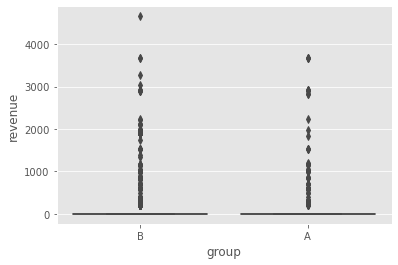

In [24]:
# Строим боксплоты по группам
sns.boxplot(x="group", y="revenue", data=df)

**По графику видно, что в группе A и B есть выбросы**

<AxesSubplot:xlabel='revenue'>

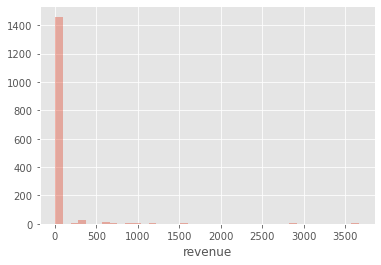

In [25]:
# Строим гистограмму по группе Контроль
sns.distplot(df[df.group == 'A'].revenue, kde=False)

In [26]:
# Проверим нормальность распределения методом Шапиро_Уилкса
stats.shapiro(df[df.group == 'A'].revenue)

ShapiroResult(statistic=0.15534335374832153, pvalue=0.0)

In [27]:
stats.shapiro(df[df.group == 'B'].revenue)

ShapiroResult(statistic=0.18183785676956177, pvalue=0.0)

<AxesSubplot:xlabel='revenue'>

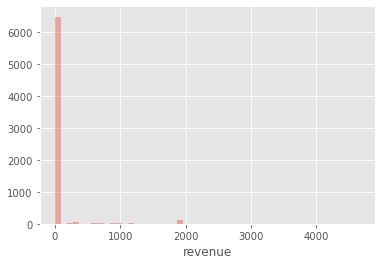

In [28]:
# Строим гистограмму по группе Контроль
sns.distplot(df[df.group == 'B'].revenue, kde=False)

**Ho — нормальность распределения, то здесь мы можем сделать вывод, что распределение отклоняется от нормального.**


In [29]:
# Смотрим разницу между количеством users по группам
results = stats.mannwhitneyu(df[df['group']=='A']['user_id'], df[df['group']=='B']['user_id'])
alpha = 0.05
print('P-value:{}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Разница в количестве посетителей в группах A и B статистически значима\n')
else:
    print('Разница в количестве посетителей в группах A и B статистически НЕ значима\n')

P-value:0.3270157556281671
Разница в количестве посетителей в группах A и B статистически НЕ значима



**Кол-во выборки для A/B тестирования корректно подобрано, статистически значимой разницы
в количестве клиентов м/у группами не обнаружено**

### Функция bootstrap

In [30]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

### Гипотезы

Но - Статистически значимой разницы между группами A и B нет, то есть использование новой и старой моделей оплаты шаблонов не имеют статистически значимой разницы.

H1 - Статистически значимая разница между группами A и B есть, то есть использование новой и старой моделей оплаты шаблонов имеют статистически значимую разницу.

In [31]:
# Группы без выбросов
df_without_outliers_group_a = df[(df['group'] == 'A') & (df['revenue'] <=1200)] 
df_without_outliers_group_b = df[(df['group'] == 'B') & (df['revenue'] <=2500)] 

**Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений.
Применим сначала bootstrap**

  0%|          | 0/1000 [00:00<?, ?it/s]

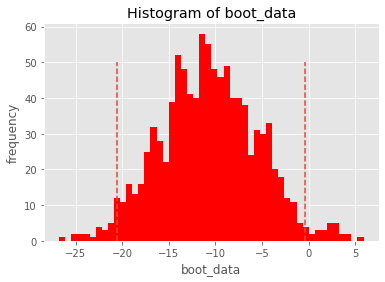

{'boot_data': [-8.670145524033515,
  -13.457298250771718,
  -5.261208290460091,
  -13.91033367631927,
  -5.448184624430398,
  -10.693958547699545,
  -4.942084374540644,
  -10.151991768337497,
  1.1810965750404234,
  -20.86182566514773,
  -16.351462590033808,
  -11.410848155225636,
  -8.501690430692342,
  -13.179920623254446,
  -11.167720123474938,
  -5.788181684550933,
  -11.562104953696899,
  -11.066147287961194,
  -4.04453917389387,
  -10.558283110392473,
  -10.116713214758194,
  -21.11480229310598,
  -19.255328531530207,
  -11.87799500220491,
  -7.580479200352785,
  -13.506394237836249,
  -20.156548581508158,
  -13.267970013229458,
  -9.005732764956637,
  -12.2531236219315,
  -17.82331324415699,
  -13.468175804792004,
  -20.775981184771425,
  -17.55343230927532,
  -12.431133323533736,
  -10.180802587093929,
  -12.472291636042922,
  3.2738497721593416,
  -9.300161693370573,
  -5.491988828458033,
  -7.024254005585771,
  -9.602969278259591,
  -2.6209025429957373,
  -21.68366896957225,


In [32]:
# С выбросами среднее
get_bootstrap(
    df[df.group == 'A'].revenue, # числовые значения первой выборки
    df[df.group == 'B'].revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

  0%|          | 0/1000 [00:00<?, ?it/s]

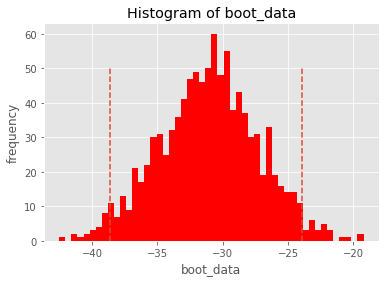

{'boot_data': [-35.740762549683495,
  -29.572942735168557,
  -37.80612395112616,
  -22.309436184307376,
  -29.734138083321067,
  -36.25202414249963,
  -29.09244810834683,
  -22.195495362873547,
  -34.55969380244369,
  -32.26748123067864,
  -26.855292212571765,
  -26.661710584425144,
  -31.514205800088327,
  -36.40718386574415,
  -26.65567495951715,
  -31.939054909465625,
  -35.07757986162226,
  -33.46636243191521,
  -31.259384660680112,
  -27.913293095833946,
  -31.240394523774473,
  -32.43500662446636,
  -32.96790814073311,
  -31.910348888561753,
  -34.557632857353155,
  -30.790372442219933,
  -24.442219932283233,
  -30.326807007213308,
  -23.955395259826293,
  -32.2652730752245,
  -36.697777123509496,
  -32.5199470042691,
  -29.427646106285884,
  -27.7331076107758,
  -27.515530693360812,
  -27.97526865891359,
  -31.03547769762991,
  -28.46444869718828,
  -24.997203003091418,
  -36.716178418960695,
  -35.37170616811424,
  -28.610039746798176,
  -29.817459149124097,
  -28.1990284116001

In [33]:
# Без выбросов среднее
get_bootstrap(
    df_without_outliers_group_a.revenue, # числовые значения первой выборки
    df_without_outliers_group_b.revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

### Вывод
p_value < 0.05 в обеих проверках, значит мы говорим о том, что между средними групп A и B есть статистически значимая разница и отклоняем Ho.

**Проверим равенство распределений по Манна-Уитни**

In [34]:
# Группы с выбросами
mannwhitneyu(df[df.group == 'A'].revenue, 
             df[df.group == 'B'].revenue)

MannwhitneyuResult(statistic=5252073.0, pvalue=0.5107994153653242)

In [35]:
# Группы без выбросов
mannwhitneyu(df_without_outliers_group_a.revenue, 
             df_without_outliers_group_b.revenue)

MannwhitneyuResult(statistic=5150701.5, pvalue=0.461954328601076)

### Вывод

Манн-Уитни очень чувствителен к дисбалансу в группах. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект). Значит его результат (p value > 0.05) может привести к ошибке 2 рода. 

### Конверсия

In [36]:
print('Количество покупок в группе A - ', df[(df['group'] == 'A') & (df['revenue'] > 0)]['revenue'].count())
print('Количество покупок в группе B - ', df[(df['group'] == 'B') & (df['revenue'] > 0)]['revenue'].count())

Количество покупок в группе A -  78
Количество покупок в группе B -  314


In [84]:
# Начальная конверсия
df[(df['group'] == 'A') & (df['revenue'] > 0)]['revenue'].count() \
/ df[df['group'] == 'A']['user_id'].count()

0.05071521456436931

In [85]:
# Результирующая конверсия
df[(df['group'] == 'B') & (df['revenue'] > 0)]['revenue'].count() \
/ df[df['group'] == 'B']['user_id'].count()

0.046156107599588415

**Конверсия группы A больше на 0.01 чем в группе B**

### ARPU

In [42]:
df_group_A = df.query('group == "A"')
df_group_A

,user_id,country,platform,sex,group,revenue
8,4038,Russia,android,female,A,0.00
11,2427,Sweden,android,female,A,0.00
22,6772,Sweden,android,female,A,0.00
23,518,Russia,android,female,A,0.00
27,5220,Russia,ios,male,A,0.00
...,...,...,...,...,...,...
8298,3408,Russia,ios,male,A,0.00
8303,4519,Russia,ios,male,A,0.00
8306,7680,Russia,ios,male,A,0.00
8328,7111,Russia,android,male,A,0.00


In [44]:
df_group_B = df.query('group == "B"')
df_group_B

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,0.00
1,1735,Sweden,ios,male,B,0.00
2,7697,Russia,android,male,B,0.00
3,1421,Sweden,android,female,B,0.00
4,1704,Russia,ios,male,B,0.00
...,...,...,...,...,...,...
8335,3116,Russia,ios,male,B,0.00
8336,2417,Sweden,ios,female,B,0.00
8338,4594,Sweden,android,female,B,0.00
8339,7430,Sweden,ios,female,B,0.00


In [75]:
ARPU_A = (df_group_A['revenue'].sum()/df_group_A['user_id'].count()).round(0)

In [76]:
ARPU_B = (df_group_B['revenue'].sum()/df_group_B['user_id'].count()).round(0)

In [77]:
print('ARPU в группе A =', ARPU_A )
print()
print('ARPU в группе B =', ARPU_B )

ARPU в группе A = 48.0

ARPU в группе B = 59.0


### ARPPU

In [81]:
ARPPU_A = (df_group_A['revenue'].sum()/df_group_A.query('revenue > 0')['user_id'].count()).round()
ARPPU_A

944.0

In [82]:
ARPPU_B = (df_group_B['revenue'].sum()/df_group_B.query('revenue > 0')['user_id'].count()).round()
ARPPU_B

1268.0

In [83]:
print('ARPPU в группе A =', ARPPU_A )
print()
print('ARPPU в группе B =', ARPPU_B )

ARPPU в группе A = 944.0

ARPPU в группе B = 1268.0


**ARPPU в группе B больше чем в группе A на 25%. В данном контексте ARPPU является и средним чеком тоже.**

**ARPU в группе B больше, чем в группе A на 19%**

## Общий вывод

Активные пользователи 8341 это представители стран России (65%) и Швеции(35%).
Больше всего покупок в России совершали мужчины (51%), женщины (49%). Но покупки женщин дороже.
                     в Швеции мужчины 52%, женщины 48%. В Швеции мужские покупки дороже.
                     
Больше всего покупок в России совершали на Android (51%), ios (49%)
                     в Швеции Android 57%, ios 43%                   
В обеих странах на Android Revenue больше, чем на IOS.

B эксперименте участвовали в группе A- Контрольная 1538 человек, в группе B-тестовой 6803 человек.
Распределение отклоняется от нормального после проверки методом Шапиро-Уилка.
По боксплотам видно, что в данных есть выбросы.

Конверсия группы A 0.05% - начальная конверсия. 
Чтобы посчитать насколько увеличится прибыль при увеличении конверсии на 1% нам нужно знать маржинальность. Чобы ее посчитать нужно знать затраты. Раз мы ничего этого не имеем в данных, то будем считать, что увеличение конверсии даже на 0.01% даст нам значимое для компании увеличение Revenue.

Цель эксперимента - увеличение конверсии в покупку.

Количество покупок в группе A -  78
Количество покупок в группе B -  314

Кол-во выборки для A/B тестирования корректно подобрано, статистически значимой разницы в количестве клиентов м/у группами не обнаружено.

В группах A и B нет пересечений пользователей. Хотя механизм бутстрапа построен так, что одно наблюдение может встретиться много раз в одном и том же распределении.


**Гипотезы**

    Но - Статистически значимой разницы между группами A и B нет, то есть использование новой и старой моделей оплаты шаблонов не имеют статистически значимой разницы.

    H1 - Статистически значимая разница между группами A и B есть, то есть использование новой и старой моделей оплаты шаблонов имеют статистически значимую разницу

Манн-Уитни очень чувствителен к дисбалансу в группах. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект). Значит его результат (p value > 0.05) может привести к ошибке 2 рода. 

По результату эксперимента мы выявили методом bootstrap, что статистически значимая разница между группами есть. Значит мы отклоняем Ho.

**ARPPU в группе B больше чем в группе A на 25%. В данном контексте ARPPU является и средним чеком тоже.**

**ARPU в группе B больше, чем в группе A на 19%**


**Конверсия в покупку в контрольной группе понизилась на 0.01%, тем не менее ARPPU и ARPU в тестовой группе больше. Считаю челесообразным продолжить тестирование, так как получается, что количество покупок у группы A больше, а денег она приносит меньше. Соответственно на этой стадии эксперимента нельзя дать ответ выкатывать новую версию на всех или же результат случаен.**




**Дашборд старая версия https://public.tableau.com/views/Carpov_final_project/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link**

**Новая версия с измененным размером https://public.tableau.com/app/profile/marina4608/viz/Carpov_final_project_with_corr/Dashboard1?publish=yes**